In [77]:
"""
    Attempt for the controlled version:
"""
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import construct_ising_local_term, reduce_list, X, I2, get_perms
from ansatz_sparse import ansatz_sparse
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import random_statevector

Lx, Ly = (4, 4)
L = Lx*Ly
t = 0.25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4

V1 = scipy.linalg.expm(-1j*t*hloc1/4)
V2 = scipy.linalg.expm(-1j*t*hloc2/2)
V3 = scipy.linalg.expm(-1j*t*hloc1/2)
V4 = scipy.linalg.expm(-1j*t*hloc2)
YZ = np.kron(Y, Z)

"""perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]"""
#perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
#perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
#perms_v = [[0, 1, 2, 3], [1, 0, 3, 2]]
#perms_h = [[0, 2, 1, 3], [2, 0, 3, 1]]
perms_v, perms_h = get_perms(Lx, Ly)

Vlist_start = [YZ, V1, V2, V1, YZ, YZ, V3, V4, V3, YZ, YZ, V1, V2, V1, YZ]
Vlist_reduced = [V1, V2, V1, V3, V4, V3, V1, V2, V1]
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers


# 12 layers with 6 being controlled, 9 parameters in total.
state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist_start, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

Trotter error of the starting point:  0.18759848113540384


Current error:  0.08563168820711778
Current error:  0.03574975871314787
Current error:  0.026875050711299205
Current error:  0.02070715421878684
Current error:  0.019093986067406164
Current error:  0.019093986067406164
0.019093986067406164


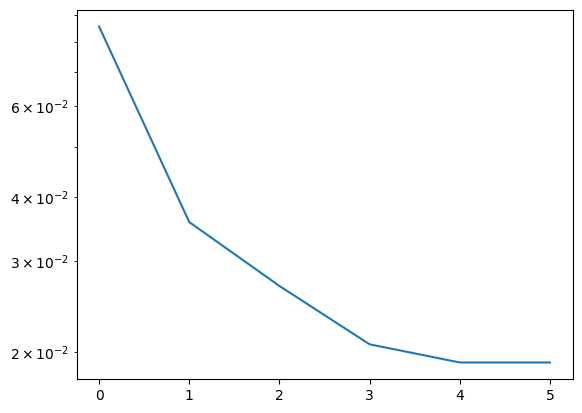

In [9]:
from optimize_sparse import optimize, err

Vlist, f_iter, err_iter = optimize(L, hamil, t, Vlist, perms_extended, perms_reduced=perms_ext_reduced, 
                                   control_layers=control_layers, rS=1, niter=5)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [15]:
with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter7_rS1_2hloc.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [79]:

with h5py.File(f"./tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_niter7_rS1_2hloc.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

In [80]:
"""
    Test operations.
"""

Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)

state = random_statevector(2**L).data
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, state) - expm_multiply(
    1j * t * hamil, state), ord=2) + np.linalg.norm(ansatz_sparse(Vlist_reduced, L, perms_ext_reduced, state) - expm_multiply(
    -1j * t * hamil, state), ord=2))/2)

Trotter error of the starting point:  0.019083824805218447


In [13]:
sys.path.append("../../src/controlled_unitary_optimizer")
sys.path.append("../../src/brickwall_ansatz")
from optimize_3q import optimize_3q 
from utils_3q import make_controlled, random_unitary

Xlists_opt = {}
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]

for i in control_layers:
    cU = make_controlled(Vlist[i])
    f_best, err_best, Glist_best = (0, 2, None)
    for _ in range(10):
        Xlist_start = [random_unitary(4) for i in range(len(perms_qc))]
        Xlist, f_iter, err_iter = optimize_3q(L, cU, Xlist_start, perms_qc, niter=1000)
        if err_iter[-1] < err_best:
            f_best, err_best, Xlist_best = (f_iter[-1], err_iter[-1], Xlist)
    print("Best f: ", f_best)
    print("Best err: ", err_best)
    Xlists_opt[i] = Xlist_best

/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = rsq / dHd
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/rqcopt/trust_region.py:40: RuntimeWarning: invalid value encountered in scalar divide
  rho = (f(x_next) - fx) / (np.dot(grad, eta) + 0.5 * np.dot(eta, hess @ eta))


Best f:  -7.999999999999925
Best err:  2.191724639327272e-07
Best f:  -7.999999999999967
Best err:  1.7419223816536136e-07
Best f:  -7.999999999999936
Best err:  1.972197712435539e-07
Best f:  -7.999999999999942
Best err:  1.7754426930958346e-07
Best f:  -7.999999999999891
Best err:  2.630298476652839e-07
Best f:  -7.999999999999909
Best err:  2.093713867259195e-07


In [81]:
# Save the optimal gates.

for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter7_rS1_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "w") as file:
        file.create_dataset(f"Xlist_{i}", data=Xlists_opt[i])

In [ ]:
Xlists_opt1 = {}
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_niter50_rS6_DECOMPOSE_n{len(perms_qc)}_layer{i}.hdf5", "r") as file:
        Xlists_opt1[i] = file[f"Xlist_{i}"][:]

In [82]:
from qiskit import Aer, execute, transpile
from qiskit.circuit.library import CYGate, CZGate, IGate, CXGate
from qiskit.converters import circuit_to_dag
from qiskit.providers.aer.noise import NoiseModel, errors
from qiskit import Aer, execute, transpile
from scipy import sparse as sp

qc = qiskit.QuantumCircuit(L+1)
qc.x(L)
for i, V in enumerate(Vlist):
    layer = i
    if i in control_layers:
        Glist = Xlists_opt[i]
        qc_3 = qiskit.QuantumCircuit(3)
        for j, G in enumerate(Glist):
            qc_3.unitary( G, (3-1-perms_qc[j][1], 3-1-perms_qc[j][0]))

        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.append(qc_3.to_gate(), [L-perm[2*j]-1, L-perm[2*j+1]-1, L])
        
    else:
        for perm in perms_extended[layer]:
            for j in range(L//2):
                qc.unitary(V, [L-perm[2*j]-1, L-perm[2*j+1]-1])
qc.x(L)


ccU_cxs= []
ccU_errs = []
for t in [.25, .5, 1, 2]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    for i in range(int(t/0.25)):
        qc_ext1.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    for i in range(int(t/0.25)):
        qc_ext2.append(qc.to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()
    
    ccU_errs.append(err)
    ccU_cxs.append(count_ops['unitary'])
    print(f"t={t}, Gate Count: ", count_ops['unitary'], " Trotter error: ", err)

/tmp/ipykernel_27482/1096984358.py:38: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
/tmp/ipykernel_27482/1096984358.py:46: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data


t=0.25, Gate Count:  576  Trotter error:  0.019078089549256057
t=0.5, Gate Count:  1152  Trotter error:  0.029779510582596095
t=1, Gate Count:  2304  Trotter error:  0.048258151298834484
t=2, Gate Count:  4608  Trotter error:  0.07485142107455334


In [87]:
"""
    Now here is to compare the performance of the ccU circuit
    with the 1st and 2nd order Trotter circuits, in terms of 
    gate count vs Trotter error. I demonstrate it on L=10 system.
"""


def controlled_trotter(c1, L, Lx, Ly, J, g, dag=False, nsteps=1):
    if c1/(2*nsteps) > 0.125:
        nsteps = int(np.ceil(c1/(2 * 0.125)))
        print("nsteps set to: ", nsteps)
        print("dt set to: ",  c1/(2*nsteps))
    t = c1/(2*nsteps)

    perms_v, perms_h = get_perms(Lx, Ly)
    indices = [0,   1,  0]
    coeffs  = [.5,  1, .5]
    perms_ext = ([perms_v, perms_h])*len(indices)
    
    hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
    hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
    hlocs = (hloc1, hloc2)

    K = []
    for i, perms in enumerate(perms_ext):
        perm = perms[0]
        K_layer = [None for _ in range(L)]
        for j in range(len(perm)//2):
            K_layer[perm[2*j]] = CYGate
            K_layer[perm[2*j+1]] = CZGate
        K.append(K_layer)

    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(scipy.linalg.expm(-1j*c*t*hlocs[i]))
    Vlist_gates = []
    for V in Vlist_start:
        qc2 = qiskit.QuantumCircuit(2)
        qc2.unitary(V, [0, 1], label='str')
        Vlist_gates.append(qc2)


    qc = qiskit.QuantumCircuit(L+1)
    for n in range(nsteps):
        for layer, qc_gate in enumerate(Vlist_gates):

            perms = perms_v
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])
            qc.x(L)
            for j in range(L):
                if K[2*layer][j]:
                    qc.append(K[2*layer][j](), [L, L-1-j])
            qc.x(L)

            perms = perms_h
            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
            
            for perm in perms:
                for j in range(len(perm)//2):
                    qc.append(qc_gate.to_gate(), [L-(perm[2*j]+1), L-(perm[2*j+1]+1)])

            qc.x(L)
            for j in range(L):
                if K[2*layer+1][j]:
                    qc.append(K[2*layer+1][j](), [L, L-1-j])
            qc.x(L)
    return qc

    
trotter2_cxs= []
trotter2_errs = []
for t in [0.25, .5, 1, 2]:
    state = random_statevector(2**L).data
    qc_ext1 = qiskit.QuantumCircuit(L+1)
    qc_ext1.initialize(state, [i for i in range(L)])
    qc_ext1.append(controlled_trotter(2*t, 16, 4, 4, J, g).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data
    
    qc_ext2 = qiskit.QuantumCircuit(L+1)
    qc_ext2.initialize(state, [i for i in range(L)])
    qc_ext2.x(L)
    qc_ext2.append(controlled_trotter(2*t, 16, 4, 4, J, g).to_gate(), [i for i in range(L+1)])
    backend = Aer.get_backend("statevector_simulator")
    sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data

    ket_0 = np.array([1, 0])
    ket_1 = np.array([0, 1])
    exact_v1 = np.kron(ket_0, expm_multiply(1j * t * hamil, state))
    exact_v2 = np.kron(ket_1, expm_multiply(-1j * t * hamil, state))
    err = (np.linalg.norm(sv1-exact_v1, ord=2) + np.linalg.norm(sv2-exact_v2, ord=2))/2
    
    noise_model = NoiseModel()
    dag = circuit_to_dag(transpile(qc_ext1, basis_gates=noise_model.basis_gates+['unitary', 'initialize', 'cx']))
    count_ops = dag.count_ops()

    trotter2_cxs.append(count_ops['cx']+count_ops['unitary'])
    trotter2_errs.append(err)

    print(f"t={t}, Gate Count: ", count_ops['cx']+count_ops['unitary'], " Trotter error: ", err)

nsteps set to:  2
dt set to:  0.125


/tmp/ipykernel_27482/4040044168.py:90: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv1 = execute(transpile(qc_ext1), backend).result().get_statevector().data


nsteps set to:  2
dt set to:  0.125


/tmp/ipykernel_27482/4040044168.py:97: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  sv2 = execute(transpile(qc_ext2), backend).result().get_statevector().data


t=0.25, Gate Count:  576  Trotter error:  0.12154624786816681
nsteps set to:  4
dt set to:  0.125
nsteps set to:  4
dt set to:  0.125
t=0.5, Gate Count:  1152  Trotter error:  0.11405705461025048
nsteps set to:  8
dt set to:  0.125
nsteps set to:  8
dt set to:  0.125
t=1, Gate Count:  2304  Trotter error:  0.17798335037544372
nsteps set to:  16
dt set to:  0.125
nsteps set to:  16
dt set to:  0.125
t=2, Gate Count:  4608  Trotter error:  0.30056603733609033
